In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("whitegrid")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score, classification_report,confusion_matrix
from sklearn.metrics import  recall_score, precision_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from yellowbrick.classifier import ClassPredictionError, ROCAUC
from sklearn.pipeline  import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from xgboost import XGBClassifier

plt.rcParams["figure.figsize"] = (10,6)

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv("recom.csv"); df.head()

Unnamed: 0   Main_ID Transaction_ID                     Date  Price  Code_Product  Amount  ItemKey
0           0  90fada91       264f7a69  2022-10-07 20:53:49.153  125.0        5002.0     1.0   5002.0
1           1  9006f9ac       45c7d853  2022-09-17 15:54:57.187   19.0       35012.0     1.0      NaN
2           2  32270891       61ad76dd  2022-11-28 13:51:55.667  141.0        5005.0     1.0   5005.0
3           3  97e03e47       41ee09f6  2022-09-12 16:20:22.110    4.5       35078.5     1.0      NaN
4           4  41949228       244fe6d8  2022-10-14 18:53:43.933  129.5       49291.5     5.0      NaN

In [3]:
df.drop("Unnamed: 0", axis = 1, inplace=True)

In [4]:
df.drop("ItemKey", axis = 1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Main_ID         50000 non-null  object 
 1   Transaction_ID  50000 non-null  object 
 2   Date            50000 non-null  object 
 3   Price           50000 non-null  float64
 4   Code_Product    50000 non-null  float64
 5   Amount          50000 non-null  float64
dtypes: float64(3), object(3)
memory usage: 2.3+ MB


In [6]:
df.describe().T

count         mean           std     min      25%      50%      75%       max
Price         50000.0     62.56067     68.269624     0.5     24.5     45.5     83.0    2525.5
Code_Product  50000.0  32379.29354  21697.500334  5000.5  10013.0  40009.5  49291.5  350027.5
Amount        50000.0      1.23264      0.749353     1.0      1.0      1.0      1.0      54.0

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

In [8]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

In [9]:
summary(df)

Data shape: (50000, 6)
___________________________
Data Types:
float64           3
object            2
datetime64[ns]    1
Name: Types, dtype: int64
___________________________


Types  Counts  Uniques  Nulls                         Min                         Max
Amount                 float64   50000       22      0                         1.0                        54.0
Code_Product           float64   50000      333      0                      5000.5                    350027.5
Date            datetime64[ns]   50000    48398      0  2022-08-26 00:00:14.643000  2022-12-03 02:14:57.983000
Main_ID                 object   50000    28514      0                    00024de6                    ffff4aa9
Price                  float64   50000      795      0                         0.5                      2525.5
Transaction_ID          object   50000    48403      0                    00001871                    fffed42a

In [10]:
def duplicate_values(df):
    print("Duplicate check...")
    num_duplicates = df.duplicated(subset=None, keep='first').sum()
    if num_duplicates > 0:
        print("There are", num_duplicates, "duplicated observations in the dataset.")
        df.drop_duplicates(keep='first', inplace=True, ignore_index = True)
        print(num_duplicates, "duplicates were dropped!")
        print('*' * 100)
    else:
        print("There are no duplicated observations in the dataset.")

In [11]:
duplicate_values(df)

Duplicate check...
There are 171 duplicated observations in the dataset.
171 duplicates were dropped!
****************************************************************************************************


In [12]:
df.shape

(49829, 6)

In [13]:
a = df.groupby("Main_ID")["Price"].sum()

In [14]:
a = pd.DataFrame(a); a.head()

Price
Main_ID        
00024de6    6.0
00084856   46.0
0008e848   13.0
00096930   48.0
000c66b7   62.0

In [15]:
a.rename(columns = {'Price':'Total_Price'}, inplace = True); a.head()

Total_Price
Main_ID              
00024de6          6.0
00084856         46.0
0008e848         13.0
00096930         48.0
000c66b7         62.0

In [16]:
df = pd.merge(df, a, on = "Main_ID")
df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0
1  9006f9ac       45c7d853 2022-09-17 15:54:57.187   19.0       35012.0     1.0         90.5
2  9006f9ac       c33a52d9 2022-09-08 15:40:28.463   23.5       30026.5     1.0         90.5
3  9006f9ac       4a7fe1a6 2022-09-02 17:01:10.073   28.5       49291.5     1.0         90.5
4  9006f9ac       ec654329 2022-09-09 19:05:55.200   19.5       45002.5     1.0         90.5

In [17]:
b = df.Main_ID.value_counts()

In [18]:
b = pd.DataFrame(b); b.head()

Main_ID
751131ee       51
734264e5       47
d0778daf       39
c33b52b6       36
bef02fe1       35

In [19]:
b.index.set_names("Main_ID", inplace=True)

In [20]:
b.rename(columns = {'Main_ID':'Total_Frequency'},  inplace = True); b.head()

Total_Frequency
Main_ID                  
751131ee               51
734264e5               47
d0778daf               39
c33b52b6               36
bef02fe1               35

In [21]:
df = pd.merge(df, b, on = "Main_ID")
df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1
1  9006f9ac       45c7d853 2022-09-17 15:54:57.187   19.0       35012.0     1.0         90.5                4
2  9006f9ac       c33a52d9 2022-09-08 15:40:28.463   23.5       30026.5     1.0         90.5                4
3  9006f9ac       4a7fe1a6 2022-09-02 17:01:10.073   28.5       49291.5     1.0         90.5                4
4  9006f9ac       ec654329 2022-09-09 19:05:55.200   19.5       45002.5     1.0         90.5                4

In [22]:
c = df.groupby(["Main_ID", "Code_Product"]).sum(); c.head()

Price  Amount  Total_Price  Total_Frequency
Main_ID  Code_Product                                             
00024de6 35097.0         6.0     2.0          6.0                1
00084856 49291.5        22.0     1.0         46.0                2
         49292.0        24.0     1.0         46.0                2
0008e848 40002.0        13.0     1.0         13.0                1
00096930 49291.5        48.0     2.0         48.0                1

In [23]:
pivot = c.pivot_table(index = "Main_ID", columns = "Code_Product", values = "Amount")
pivot.head(20)

Code_Product  5000.5    5001.0    5001.5    5002.0    5002.5    5003.0    5004.0    5004.5    5005.0    5007.0    5008.0    5009.0    5011.0    5011.5    5012.0    5012.5    5013.0    5015.0    5017.0    5017.5    5023.0    5024.5    5025.0    5026.0    5027.0    5027.5    10000.5   10001.0   10001.5   10002.0   10003.0   10003.5   10004.0   10006.0   10013.0   10015.0   10015.5   10021.0   10021.5   10022.0   10022.5   10023.0   10023.5   10024.0   10030.5   10031.0   10032.0   10032.5   10033.0   15000.5   15001.0   15001.5   15002.0   15002.5   15003.0   15004.0   15004.5   15005.0   15005.5   15006.0   15007.0   15008.5   15009.5   15010.5   15015.0   15015.5   15016.0   15016.5   15020.5   15022.5   15029.0   15030.5   15033.0   15033.5   20000.5   20004.5   20005.5   20007.0   20007.5   20011.0   20014.5   20016.5   20022.5   20024.0   20024.5   20025.0   20025.5   20034.0   20034.5   25003.0   25003.5   25004.0   25004.5   25005.0   25005.5   30000.5   30001.5   30002.0   \
Main_ID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
00024de6           NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
00084856           NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
0008e848        

In [24]:
pivot.corr()

Code_Product      5000.5        5001.0        5001.5        5002.0    5002.5    5003.0    5004.0        5004.5        5005.0    5007.0    5008.0        5009.0    5011.0        5011.5    5012.0        5012.5    5013.0    5015.0    5017.0        5017.5    5023.0    5024.5        5025.0    5026.0    5027.0    5027.5    10000.5   10001.0   10001.5   10002.0   10003.0       10003.5       10004.0   10006.0       10013.0   10015.0   10015.5   10021.0   10021.5   10022.0   10022.5   10023.0       10023.5   10024.0   10030.5   10031.0   10032.0   10032.5   10033.0   15000.5   15001.0   15001.5   15002.0   15002.5   15003.0   15004.0   15004.5   15005.0   15005.5   15006.0   15007.0   15008.5   15009.5   15010.5   15015.0   15015.5       15016.0       15016.5   15020.5   15022.5   15029.0   15030.5   15033.0   15033.5   20000.5   20004.5   20005.5   20007.0   20007.5   20011.0   20014.5   20016.5   20022.5   20024.0   20024.5   20025.0   20025.5   20034.0   20034.5   25003.0       25003.5   \
Code_Product                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
5000.5        1.000000e+00  9.025073e-02  2.784954e-02  2.233846e-01       NaN       NaN       NaN -2.395489e-01  2.374578e-01 -0.282575       NaN  2.154701e-01       NaN  2.256946e-01  0.042796 -3.142857e-01       NaN       NaN  0.020278 -4.807407e-17 -0.189151       NaN  1.402583e-01       NaN -0.013736  0.091408  0.159417  0.250000       NaN   0.13484 -0.057706  3.567530e-01  2.737311e-01       1.0  2.393808e-01  0.187705  0.235993       NaN       NaN       NaN  0.025595 -0.044768  3.494249e-02  0.012307       NaN  0.852803       NaN  0.220000 -0.208947  0.327755       NaN       NaN  0.070368       NaN -0.337939 -0.255688  0.474957       NaN  0.188982       NaN       NaN  0.942809       NaN       NaN  0.866025       1.0  8.626028e-02 -2.006453e-01 -0.387298   0.57735       NaN -0.047405       NaN       NaN       NaN       NaN       NaN  0.166667 -0.250904       NaN       NaN       NaN       NaN -0.333333      -1.0       NaN       NaN       NaN       NaN  0.144872  1.613038e-01   
5001.0        9.025073e-02  1.000000e+00  1.804627e-01  1.651676e-01       NaN       NaN       NaN  2.453267e-01  6.785511e-01  0.174078       NaN -7.736372e-03       NaN  2.989422e-01  0.426682  1.000000e+00       NaN       NaN  0.099251           NaN       NaN       NaN -1.594218e-01       NaN  0.193327  0.151330 -0.245256       NaN       NaN       NaN -0.028481 -2.100420e-01  5.711289e-02       NaN  9.486507e-02  0.159298 -0.292770       NaN       NaN       NaN  0.255415  0.164037  6.679221e-01  0.787296       NaN  0.944911       NaN  0.159843       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN  0.530330       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN  9.079594e-01  3.172576e-01       NaN       NaN       NaN -0.500000       NaN       NaN       NaN       NaN       NaN       NaN  0.531280       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN  0.134482  4.529108e-01   
5001.5  

In [25]:
liste = np.arange(50); liste

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [26]:
RS = pd.DataFrame(liste); RS.head()

0
0  0
1  1
2  2
3  3
4  4

In [27]:
rs = pivot.corr()

In [28]:
for i in rs.columns:
    if rs[i].sort_values(ascending = False).isnull().all() == True:
        continue
    else:
        RS[i] = rs.sort_values(by = i, ascending = False).index[1:51]    

In [29]:
RS

0.0       5000.5    5001.0    5001.5    5002.0    5003.0    5004.5    5005.0    5007.0    5009.0    5011.5    5012.0    5012.5    5013.0    5015.0    5017.0    5017.5    5023.0    5025.0    5026.0    5027.0    5027.5    10000.5   10001.0   10002.0   10003.0   10003.5   10004.0   10006.0   10013.0   10015.0   10015.5   10021.0   10022.5   10023.0   10023.5   10024.0   10031.0   10032.0   10032.5   10033.0   15000.5   15001.5   15002.0   15002.5   15003.0   15004.0   15004.5   15005.0   15005.5   15008.5   15010.5   15015.0   15015.5   15016.0   15016.5   15020.5   15022.5   15030.5   20005.5   20007.0   20007.5   20014.5   20024.0   20024.5   20025.0   20034.5   25003.0   25003.5   25004.0   25004.5   30002.0   30003.0   30003.5   30008.0   30008.5   30009.0   30009.5   30014.0   30014.5   30021.5   30026.5   30027.0   30029.0   30029.5   35000.5   35001.0   35002.5   35004.5   35005.0   35005.5   35006.0   35006.5   35007.5   35011.0   35011.5   35012.5   35013.5   35018.0   \
0          0   40027.5   40054.0    5007.0    5002.0    5000.5    5004.5   35076.0    5007.0    5009.0   15000.5   10031.0    5012.5   45001.5    5000.5    5017.0   35006.0    5000.5    5025.0    5000.5   30003.5   10003.5    5001.5   10003.0   10002.0   40054.0    5017.0   48589.0   10006.0   40046.0   40027.0   10015.5    5000.5   10022.5   10023.0   20007.5   35005.0    5017.0   49292.0   10032.5   10033.0    5025.0    5009.0   15002.0   49291.5   49291.5   45001.0   49427.5    5000.5    5000.5   10022.5    5000.5    5000.5   15015.5   25003.0   15016.5   40036.0   49291.5    5000.5   20005.5   20007.0   10023.5   10004.0    5000.5   25003.0    5000.5    5011.5   25003.0   35097.0    5017.0   25004.5   10013.0   49427.5   49356.0   25003.5   30008.5   35096.5   45001.0   35005.5   30014.5   48556.5   30026.5   30027.0   10023.0   10023.0   35000.5   30021.5   45004.0   35004.5   10015.0   35005.5   10015.0   40030.0    5000.5    5000.5   10013.0    5000.5    5000.5   45004.0   
1          1   15015.5    5001.0   10033.0   20005.5    5001.0   30026.5   49292.0    5017.0   40027.0   40054.0   40036.0    5017.0   48513.0    5001.0   40028.5   40009.5   45004.0   49427.5    5001.0    5027.0   40069.5   49556.0   10013.0    5000.5   10003.0    5027.5   40002.0   10023.5   10013.0   30029.0   10000.5    5001.0   15008.5   30029.5   30029.0   10024.0   10022.5    5000.5   10003.5   49567.5   15000.5    5000.5   35005.5   49292.0   49292.0   10022.5   40028.5    5001.0    5001.0   15008.5    5001.0    5001.0   49291.5   48513.0   30029.0    5017.0    5000.5    5001.0    5000.5   49292.0   20007.5   49427.5    5001.0    5000.5    5001.0   45004.0   20024.5   25004.5   10023.5   25003.5    5000.5   40028.5    5027.0    5009.0   49292.0   48504.5   45004.0    5012.0   30021.5   35001.0   40021.5   10023.5   10023.5   10023.5   40028.0   40069.5   49291.5   35005.0   10024.0   40043.0   35006.0   45003.0    5001.0    5001.0   35011.5    5001.0    5001.0   49291.5   
2          2   10006.0   40075.5    5001.5   30029.5    5001.5    5011.5    5012.0    5001.0   40020.5    5011.5   10002.0   15016.5    5011.5    5001.5   10031.0   25003.0   49291.5   10004.0    5001.5   15004.5    5011.5   10000.5   25003.5    5001.0   10024.0   10003.5   10004.0    5012.0   35011.5   10015.0   25003.0    5001.5   10031.0   30029.0   30029.5    5001.0   10031.0    5001.0   10015.5   49291.5   40002.0    5001.0   45001.5   45001.0    5000.5    5025.0   35076.0    5001.5    5001.5    5000.5    5001.5    5001.5    5001.0   49567.5   10023.0   49292.0    5001.0   49292.0    5001.0    5000.5    5001.0    5000.5    5001.5    5001.0    5001.5    5000.5   15016.0   10001.0    5001.0   45002.5    5001.0   30008.0   35097.0   45003.0   45004.0   35076.0    5000.5   10003.0   10023.0   15016.5   35001.0    5009.0   15016.5   25003.0   40045.5   35004.5    5025.0   45002.5   40009.5   30014.0   49292.0   49291.5    5001.5    5001.5   49292.0    5001.5    5001.5   48504.5   
3          3   30008

In [30]:
RS.drop(0.0, axis = 1, inplace=True)

In [31]:
RS.shape

(50, 241)

In [32]:
df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1
1  9006f9ac       45c7d853 2022-09-17 15:54:57.187   19.0       35012.0     1.0         90.5                4
2  9006f9ac       c33a52d9 2022-09-08 15:40:28.463   23.5       30026.5     1.0         90.5                4
3  9006f9ac       4a7fe1a6 2022-09-02 17:01:10.073   28.5       49291.5     1.0         90.5                4
4  9006f9ac       ec654329 2022-09-09 19:05:55.200   19.5       45002.5     1.0         90.5                4

In [33]:
pro_fre = df.groupby("Code_Product").agg({"Amount" : ["sum"]}); pro_fre

Amount
                 sum
Code_Product        
5000.5        4708.0
5001.0         662.0
5001.5         511.0
5002.0         792.0
5002.5           5.0
5003.0          37.0
5004.0          15.0
5004.5         110.0
5005.0          68.0
5007.0          29.0
5008.0           2.0
5009.0        1432.0
5011.0          17.0
5011.5        1106.0
5012.0         887.0
5012.5          38.0
5013.0          31.0
5015.0          40.0
5017.0         460.0
5017.5          43.0
5023.0          75.0
5024.5           1.0
5025.0         382.0
5026.0           6.0
5027.0         377.0
5027.5         235.0
10000.5        103.0
10001.0         21.0
10001.5          5.0
10002.0         16.0
10003.0        482.0
10003.5         74.0
10004.0        419.0
10006.0          7.0
10013.0       1706.0
10015.0        761.0
10015.5         62.0
10021.0         28.0
10021.5         16.0
10022.0          8.0
10022.5        540.0
10023.0        583.0
10023.5        293.0
10024.0        288.0
10030.5          2.0
10031.0         24.0
10032.0         14.0
10032.5        551.0
10033.0         46.0
15000.5         47.0
15001.0          6.0
15001.5         23.0
15002.0         42.0
15002.5         26.0
15003.0         44.0
15004.0         74.0
15004.5         75.0
15005.0         85.0
15005.5          9.0
15006.0          2.0
15007.0          1.0
15008.5         18.0
15009.5          5.0
15010.5          9.0
15015.0         15.0
15015.5          9.0
15016.0        140.0
15016.5        173.0
15020.5         24.0
15022.5          9.0
15029.0          3.0
15030.5         20.0
15033.0          4.0
15033.5          3.0
20000.5          2.0
20004.5          2.0
20005.5         10.0
20007.0         23.0
20007.5         60.0
20011.0          4.0
20014.5         10.0
20016.5          7.0
20022.5          1.0
20024.0         12.0
20024.5          4.0
20025.0          6.0
20025.5          4.0
20034.0          1.0
20034.5         19.0
25003.0       1232.0
25003.5        577.0
25004.0         40.0
25004.5         76.0
25005.0          4.0
25005.5          1.0
30000.5          3.0
30001.5          1.0
30002.0        404.0
30003.0        209.0
30003.5        146.0
30008.0        124.0
30008.5         33.0
30009.0        171.0
30009.5         90.0
30014.0        142.0
30014.5        164.0
30021.5        126.0
30022.5          7.0
30025.5          3.0
30026.5        168.0
30027.0        347.0
30029.0         22.0
30029.5         39.0
35000.5        806.0
35001.0        279.0
35002.5         29.0
35004.5        152.0
35005.0        252.0
35005.5        395.0
35006.0         81.0
35006.5         77.0
35007.5          6.0
35008.0          2.0
35011.0         14.0
35011.5         38.0
35012.0          8.0
35012.5          3.0
35013.0          3.0
35013.5         21.0
35014.0          2.0
35014.5          3.0
35018.0         49.0
35018.5         76.0
35019.0          7.0
35019.5         21.0
35020.0          3.0
35020.5          8.0
35021.5          3.0
35025.5          4.0
35027.0         11.0
35030.0          1.0
35041.0          1.0
35042.0          3.0
35042.5         25.0
35049.0          4.0
35049.5          7.0
35071.0          2.0
35071.5         10.0
35072.0          1.0
35072.5          4.0
35075.0         22.0
35075.5        206.0
35076.0        999.0
35076.5         31.0
35077.0        263.0
35077.5        101.0
35078.0         82.0
35078.5        189.0
35079.0         38.0
35079.5         30.0
35080.0         65.0
35081.5          9.0
35085.5          1.0
35087.0          6.0
35087.5          4.0
35088.0         31.0
35088.5          1.0
35089.0         41.0
35089.5         14.0
35090.0         38.0
35090.5         11.0
35091.0          8.0
35091.5          4.0
35092.0          7.0
35092.5          6.0
35093.0         16.0
35093.5          3.0
35094.0          7.0
35094.5          4.0
35095.5          8.0
35096.5        572.0
35097.0        111.0
35103.5         28.0
35104.0         20.0
35105.5         30.0
35106.0        124.0
35106.5         10.0
40001.5         30.0
400

In [34]:
df = pd.merge(df, pro_fre, on = "Code_Product")
df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  (Amount, sum)
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1          792.0
1  32270891       c8a31c5a 2022-11-29 13:56:22.327   87.0        5002.0     1.0        825.0                9          792.0
2  976e7a38       e07b7c39 2022-10-16 13:41:06.843   34.5        5002.0     1.0        469.0                8          792.0
3  a8951bfb       7f443986 2022-11-23 22:23:45.807  229.0        5002.0     2.0       2071.0               10          792.0
4  58a375e6       5d6b3cfc 2022-09-23 18:12:13.210  117.5        5002.0     1.0       3397.5               24          792.0

In [35]:
df.columns

Index(['Main_ID', 'Transaction_ID', 'Date', 'Price', 'Code_Product', 'Amount', 'Total_Price', 'Total_Frequency', ('Amount', 'sum')], dtype='object')

In [36]:
df["Total_Product_Amount"] = df[('Amount', 'sum')]

In [37]:
df.drop(('Amount', 'sum'), axis = 1, inplace = True)

In [38]:
df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  Total_Product_Amount
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1                 792.0
1  32270891       c8a31c5a 2022-11-29 13:56:22.327   87.0        5002.0     1.0        825.0                9                 792.0
2  976e7a38       e07b7c39 2022-10-16 13:41:06.843   34.5        5002.0     1.0        469.0                8                 792.0
3  a8951bfb       7f443986 2022-11-23 22:23:45.807  229.0        5002.0     2.0       2071.0               10                 792.0
4  58a375e6       5d6b3cfc 2022-09-23 18:12:13.210  117.5        5002.0     1.0       3397.5               24                 792.0

In [39]:
product_totals = df.groupby("Code_Product").agg({"Price" : ["sum"], "Amount" : ["sum"]}); product_totals

Price  Amount
                   sum     sum
Code_Product                  
5000.5        327306.5  4708.0
5001.0         65184.5   662.0
5001.5         33438.5   511.0
5002.0         60696.0   792.0
5002.5           416.0     5.0
5003.0          1821.5    37.0
5004.0           881.0    15.0
5004.5         10803.5   110.0
5005.0         12953.5    68.0
5007.0          2991.5    29.0
5008.0          1002.0     2.0
5009.0        115699.5  1432.0
5011.0          1013.5    17.0
5011.5         71200.5  1106.0
5012.0         60281.5   887.0
5012.5          2666.5    38.0
5013.0          2454.0    31.0
5015.0          1168.0    40.0
5017.0         33944.0   460.0
5017.5          2615.5    43.0
5023.0          5187.5    75.0
5024.5           175.0     1.0
5025.0         28746.5   382.0
5026.0           662.5     6.0
5027.0         24903.5   377.0
5027.5         14694.0   235.0
10000.5         8459.5   103.0
10001.0         1747.0    21.0
10001.5          387.5     5.0
10002.0         1712.0    16.0
10003.0        53003.5   482.0
10003.5         7591.0    74.0
10004.0        33352.0   419.0
10006.0         1143.5     7.0
10013.0       108285.5  1706.0
10015.0        71037.5   761.0
10015.5         7341.0    62.0
10021.0         1849.0    28.0
10021.5          682.0    16.0
10022.0          553.0     8.0
10022.5        39732.5   540.0
10023.0        44031.5   583.0
10023.5        33027.0   293.0
10024.0        22527.0   288.0
10030.5          268.0     2.0
10031.0         3074.5    24.0
10032.0          970.5    14.0
10032.5        48203.0   551.0
10033.0         4796.5    46.0
15000.5         3577.0    47.0
15001.0          758.5     6.0
15001.5         1394.5    23.0
15002.0         4381.0    42.0
15002.5         1160.0    26.0
15003.0         2858.5    44.0
15004.0         4971.5    74.0
15004.5         8826.0    75.0
15005.0         2157.5    85.0
15005.5          857.0     9.0
15006.0          348.5     2.0
15007.0           33.5     1.0
15008.5         1731.5    18.0
15009.5          450.0     5.0
15010.5          659.5     9.0
15015.0         1912.5    15.0
15015.5          863.5     9.0
15016.0         8337.5   140.0
15016.5        15774.5   173.0
15020.5         1088.5    24.0
15022.5         1205.5     9.0
15029.0          335.0     3.0
15030.5         1992.5    20.0
15033.0          557.5     4.0
15033.5          267.5     3.0
20000.5          216.0     2.0
20004.5          256.0     2.0
20005.5          933.0    10.0
20007.0         2131.0    23.0
20007.5         3530.5    60.0
20011.0          295.0     4.0
20014.5          696.0    10.0
20016.5          804.5     7.0
20022.5          114.5     1.0
20024.0         1262.0    12.0
20024.5          374.0     4.0
20025.0          721.5     6.0
20025.5          554.0     4.0
20034.0          344.5     1.0
20034.5         1389.0    19.0
25003.0        93430.5  1232.0
25003.5        42364.0   577.0
25004.0         4257.0    40.0
25004.5         6559.5    76.0
25005.0          408.0     4.0
25005.5           51.0     1.0
30000.5           78.0     3.0
30001.5          136.5     1.0
30002.0         8778.5   404.0
30003.0        14683.0   209.0
30003.5        13929.5   146.0
30008.0         3785.5   124.0
30008.5          937.0    33.0
30009.0         5524.0   171.0
30009.5         2287.5    90.0
30014.0        10594.5   142.0
30014.5        16684.0   164.0
30021.5        13644.5   126.0
30022.5          269.0     7.0
30025.5           53.5     3.0
30026.5         5788.5   168.0
30027.0         9364.0   347.0
30029.0         1113.0    22.0
30029.5         1828.0    39.0
35000.5        29119.5   806.0
35001.0         1787.5   279.0
35002.5         1519.5    29.0
35004.5         6746.0   152.0
35005.0         8224.5   252.0
35005.5        12168.0   395.0
35006.0         1809.0    81.0
35006.5         1504.0    77.0
35007.5          310.5     6.0
35008.0           10.0     2.0
35011.0          308.0    14.0
35011.5         1097.0    38.0
35012.0          195.5     8.0
35012.5           

In [40]:
Product_Mean_Price = []

for i in np.arange(len(product_totals)):
    Product_Mean_Price.append(round(product_totals.iloc[i,0] / product_totals.iloc[i,1],1))

In [41]:
Product_Mean_Price = pd.DataFrame(Product_Mean_Price, index = product_totals.index)

In [42]:
Product_Mean_Price

0
Code_Product       
5000.5         69.5
5001.0         98.5
5001.5         65.4
5002.0         76.6
5002.5         83.2
5003.0         49.2
5004.0         58.7
5004.5         98.2
5005.0        190.5
5007.0        103.2
5008.0        501.0
5009.0         80.8
5011.0         59.6
5011.5         64.4
5012.0         68.0
5012.5         70.2
5013.0         79.2
5015.0         29.2
5017.0         73.8
5017.5         60.8
5023.0         69.2
5024.5        175.0
5025.0         75.3
5026.0        110.4
5027.0         66.1
5027.5         62.5
10000.5        82.1
10001.0        83.2
10001.5        77.5
10002.0       107.0
10003.0       110.0
10003.5       102.6
10004.0        79.6
10006.0       163.4
10013.0        63.5
10015.0        93.3
10015.5       118.4
10021.0        66.0
10021.5        42.6
10022.0        69.1
10022.5        73.6
10023.0        75.5
10023.5       112.7
10024.0        78.2
10030.5       134.0
10031.0       128.1
10032.0        69.3
10032.5        87.5
10033.0       104.3
15000.5        76.1
15001.0       126.4
15001.5        60.6
15002.0       104.3
15002.5        44.6
15003.0        65.0
15004.0        67.2
15004.5       117.7
15005.0        25.4
15005.5        95.2
15006.0       174.2
15007.0        33.5
15008.5        96.2
15009.5        90.0
15010.5        73.3
15015.0       127.5
15015.5        95.9
15016.0        59.6
15016.5        91.2
15020.5        45.4
15022.5       133.9
15029.0       111.7
15030.5        99.6
15033.0       139.4
15033.5        89.2
20000.5       108.0
20004.5       128.0
20005.5        93.3
20007.0        92.7
20007.5        58.8
20011.0        73.8
20014.5        69.6
20016.5       114.9
20022.5       114.5
20024.0       105.2
20024.5        93.5
20025.0       120.2
20025.5       138.5
20034.0       344.5
20034.5        73.1
25003.0        75.8
25003.5        73.4
25004.0       106.4
25004.5        86.3
25005.0       102.0
25005.5        51.0
30000.5        26.0
30001.5       136.5
30002.0        21.7
30003.0        70.3
30003.5        95.4
30008.0        30.5
30008.5        28.4
30009.0        32.3
30009.5        25.4
30014.0        74.6
30014.5       101.7
30021.5       108.3
30022.5        38.4
30025.5        17.8
30026.5        34.5
30027.0        27.0
30029.0        50.6
30029.5        46.9
35000.5        36.1
35001.0         6.4
35002.5        52.4
35004.5        44.4
35005.0        32.6
35005.5        30.8
35006.0        22.3
35006.5        19.5
35007.5        51.8
35008.0         5.0
35011.0        22.0
35011.5        28.9
35012.0        24.4
35012.5        20.5
35013.0        22.7
35013.5        47.3
35014.0         7.5
35014.5        66.3
35018.0        38.5
35018.5        25.4
35019.0        15.0
35019.5         8.5
35020.0        23.7
35020.5        34.1
35021.5        26.2
35025.5         6.9
35027.0         2.4
35030.0         2.0
35041.0       117.0
35042.0        20.2
35042.5        10.6
35049.0         9.2
35049.5         3.3
35071.0         8.5
35071.5        30.6
35072.0        25.5
35072.5         6.2
35075.0         4.5
35075.5         9.6
35076.0         6.4
35076.5        15.6
35077.0         8.0
35077.5         5.9
35078.0        11.2
35078.5         7.2
35079.0         6.2
35079.5         6.8
35080.0         7.7
35081.5        44.6
35085.5         7.5
35087.0         5.5
35087.5        11.8
35088.0        12.2
35088.5        24.5
35089.0        11.8
35089.5        53.1
35090.0        11.1
35090.5        31.0
35091.0         5.6
35091.5        13.6
35092.0        28.5
35092.5        21.1
35093.0        12.0
35093.5        12.0
35094.0        10.2
35094.5        18.5
35095.5        10.0
35096.5         3.9
35097.0         6.1
35103.5        30.4
35104.0        34.0
35105.5         9.0
35106.0         7.7
35106.5        10.8
40001.5        29.8
40002.0        17.8
40002.5        15.0
40003.0        16.7
40009.5         8.6
40017.5        23.7
40019.0        17.1
40019.5        18.3
40020.5        22.8
40021.5        20.7
40026.5        13.7
40027.0        18.

In [43]:
df = pd.merge(df, Product_Mean_Price, on = "Code_Product")
df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  Total_Product_Amount     0
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1                 792.0  76.6
1  32270891       c8a31c5a 2022-11-29 13:56:22.327   87.0        5002.0     1.0        825.0                9                 792.0  76.6
2  976e7a38       e07b7c39 2022-10-16 13:41:06.843   34.5        5002.0     1.0        469.0                8                 792.0  76.6
3  a8951bfb       7f443986 2022-11-23 22:23:45.807  229.0        5002.0     2.0       2071.0               10                 792.0  76.6
4  58a375e6       5d6b3cfc 2022-09-23 18:12:13.210  117.5        5002.0     1.0       3397.5               24                 792.0  76.6

In [44]:
df.rename(columns = {0:'Product_Mean_Price'},  inplace = True); df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  Total_Product_Amount  Product_Mean_Price
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1                 792.0                76.6
1  32270891       c8a31c5a 2022-11-29 13:56:22.327   87.0        5002.0     1.0        825.0                9                 792.0                76.6
2  976e7a38       e07b7c39 2022-10-16 13:41:06.843   34.5        5002.0     1.0        469.0                8                 792.0                76.6
3  a8951bfb       7f443986 2022-11-23 22:23:45.807  229.0        5002.0     2.0       2071.0               10                 792.0                76.6
4  58a375e6       5d6b3cfc 2022-09-23 18:12:13.210  117.5        5002.0     1.0       3397.5               24                 792.0                76.6

In [45]:
df["Price_Difference"] = df["Product_Mean_Price"] - df["Price"]; df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  Total_Product_Amount  Product_Mean_Price  Price_Difference
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1                 792.0                76.6             -48.4
1  32270891       c8a31c5a 2022-11-29 13:56:22.327   87.0        5002.0     1.0        825.0                9                 792.0                76.6             -10.4
2  976e7a38       e07b7c39 2022-10-16 13:41:06.843   34.5        5002.0     1.0        469.0                8                 792.0                76.6              42.1
3  a8951bfb       7f443986 2022-11-23 22:23:45.807  229.0        5002.0     2.0       2071.0               10                 792.0                76.6            -152.4
4  58a375e6       5d6b3cfc 2022-09-23 18:12:13.210  117.5        5002.0     1.0       3397.5               24                 792.0                76.6             -40.9

In [46]:
df.sort_values(by="Total_Price")

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  Total_Product_Amount  Product_Mean_Price  Price_Difference
19455  088bf0ef       abd696b4 2022-11-22 14:40:38.270    0.5       45004.0     1.0          0.5                1                4507.0                38.9              38.4
48044  a7b5f707       335a3160 2022-10-22 13:52:52.340    0.5       40060.0     1.0          0.5                1                  28.0                18.6              18.1
40607  7995883f       c990ddc8 2022-11-08 16:31:07.507    0.5       45003.0     1.0          0.5                1                 265.0                30.3              29.8
14471  af2c7001       481e947c 2022-11-08 15:11:49.817    0.5        5000.5     2.0          0.5                1                4708.0                69.5              69.0
34415  202d0cc5       13ef6d8e 2022-10-18 15:12:33.017    0.5       40009.5     1.0          0.5                1                 974.0                 8.6               8.1
...         ...            ...                     ...    ...           ...     ...          ...              ...                   ...                 ...               ...
48141  751131ee       af9df159 2022-10-22 15:23:20.047  281.0       10031.0     1.0      28082.5               51                  24.0               128.1            -152.9
22955  751131ee       f947b968 2022-11-26 21:47:09.890  453.5       10013.0     1.0      28082.5               51                1706.0                63.5            -390.0
6023   751131ee       39276689 2022-08-29 20:11:48.690  431.5        5005.0     1.0      28082.5               51                  68.0               190.5            -241.0
1439   751131ee       95308062 2022-11-16 17:11:38.180  502.0       49291.5     1.0      28082.5               51                5673.0                38.1            -463.9
6022   751131ee       2563b958 2022-09-01 21:09:08.557  857.0        5005.0     4.0      28082.5               51                  68.0               190.5            -666.5

[49829 rows x 11 columns]

In [47]:
df["Product_Total_Price"] = df["Total_Product_Amount"] * df["Product_Mean_Price"]; df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  Total_Product_Amount  Product_Mean_Price  Price_Difference  Product_Total_Price
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1                 792.0                76.6             -48.4              60667.2
1  32270891       c8a31c5a 2022-11-29 13:56:22.327   87.0        5002.0     1.0        825.0                9                 792.0                76.6             -10.4              60667.2
2  976e7a38       e07b7c39 2022-10-16 13:41:06.843   34.5        5002.0     1.0        469.0                8                 792.0                76.6              42.1              60667.2
3  a8951bfb       7f443986 2022-11-23 22:23:45.807  229.0        5002.0     2.0       2071.0               10                 792.0                76.6            -152.4              60667.2
4  58a375e6       5d6b3cfc 2022-09-23 18:12:13.210  117.5        5002.0     1.0       3397.5               24                 792.0                76.6             -40.9              60667.2

In [48]:
product_list = df.groupby("Main_ID").agg({"Code_Product" : ["unique"]}); product_list

Code_Product
                      unique
Main_ID                     
00024de6           [35097.0]
00084856  [49291.5, 49292.0]
0008e848           [40002.0]
00096930           [49291.5]
000c66b7   [5002.0, 45001.0]
...                      ...
fff8b1c4           [35077.0]
fff905d0           [49292.0]
fff9726b  [30003.0, 45001.5]
fffa332b           [49556.0]
ffff4aa9            [5009.0]

[28514 rows x 1 columns]

In [49]:
df = pd.merge(df, product_list, on = "Main_ID")
df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  Total_Product_Amount  Product_Mean_Price  Price_Difference  Product_Total_Price                             (Code_Product, unique)
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1                 792.0                76.6             -48.4              60667.2                                           [5002.0]
1  32270891       c8a31c5a 2022-11-29 13:56:22.327   87.0        5002.0     1.0        825.0                9                 792.0                76.6             -10.4              60667.2  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
2  32270891       f0ee0f17 2022-11-07 17:13:13.600   37.5       49291.5     1.0        825.0                9                5673.0                38.1               0.6             216141.3  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
3  32270891       61ad76dd 2022-11-28 13:51:55.667  141.0        5005.0     1.0        825.0                9                  68.0               190.5              49.5              12954.0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
4  32270891       ba96209d 2022-11-06 19:27:12.583   49.5       49292.0     1.0        825.0                9                5975.0                39.4             -10.1             235415.0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...

In [50]:
df.columns

Index(['Main_ID', 'Transaction_ID', 'Date', 'Price', 'Code_Product', 'Amount', 'Total_Price', 'Total_Frequency', 'Total_Product_Amount', 'Product_Mean_Price', 'Price_Difference', 'Product_Total_Price', ('Code_Product', 'unique')], dtype='object')

In [51]:
df["Product_List"] = df[('Code_Product', 'unique')]; df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  Total_Product_Amount  Product_Mean_Price  Price_Difference  Product_Total_Price                             (Code_Product, unique)                                       Product_List
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1                 792.0                76.6             -48.4              60667.2                                           [5002.0]                                           [5002.0]
1  32270891       c8a31c5a 2022-11-29 13:56:22.327   87.0        5002.0     1.0        825.0                9                 792.0                76.6             -10.4              60667.2  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
2  32270891       f0ee0f17 2022-11-07 17:13:13.600   37.5       49291.5     1.0        825.0                9                5673.0                38.1               0.6             216141.3  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
3  32270891       61ad76dd 2022-11-28 13:51:55.667  141.0        5005.0     1.0        825.0                9                  68.0               190.5              49.5              12954.0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
4  32270891       ba96209d 2022-11-06 19:27:12.583   49.5       49292.0     1.0        825.0                9                5975.0                39.4             -10.1             235415.0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...

In [52]:
df.drop(('Code_Product', 'unique'), axis = 1, inplace = True); df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  Total_Product_Amount  Product_Mean_Price  Price_Difference  Product_Total_Price                                       Product_List
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1                 792.0                76.6             -48.4              60667.2                                           [5002.0]
1  32270891       c8a31c5a 2022-11-29 13:56:22.327   87.0        5002.0     1.0        825.0                9                 792.0                76.6             -10.4              60667.2  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
2  32270891       f0ee0f17 2022-11-07 17:13:13.600   37.5       49291.5     1.0        825.0                9                5673.0                38.1               0.6             216141.3  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
3  32270891       61ad76dd 2022-11-28 13:51:55.667  141.0        5005.0     1.0        825.0                9                  68.0               190.5              49.5              12954.0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
4  32270891       ba96209d 2022-11-06 19:27:12.583   49.5       49292.0     1.0        825.0                9                5975.0                39.4             -10.1             235415.0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...

In [53]:
RS.head()

5000.5    5001.0    5001.5    5002.0    5003.0    5004.5    5005.0    5007.0    5009.0    5011.5    5012.0    5012.5    5013.0    5015.0    5017.0    5017.5    5023.0    5025.0    5026.0    5027.0    5027.5    10000.5   10001.0   10002.0   10003.0   10003.5   10004.0   10006.0   10013.0   10015.0   10015.5   10021.0   10022.5   10023.0   10023.5   10024.0   10031.0   10032.0   10032.5   10033.0   15000.5   15001.5   15002.0   15002.5   15003.0   15004.0   15004.5   15005.0   15005.5   15008.5   15010.5   15015.0   15015.5   15016.0   15016.5   15020.5   15022.5   15030.5   20005.5   20007.0   20007.5   20014.5   20024.0   20024.5   20025.0   20034.5   25003.0   25003.5   25004.0   25004.5   30002.0   30003.0   30003.5   30008.0   30008.5   30009.0   30009.5   30014.0   30014.5   30021.5   30026.5   30027.0   30029.0   30029.5   35000.5   35001.0   35002.5   35004.5   35005.0   35005.5   35006.0   35006.5   35007.5   35011.0   35011.5   35012.5   35013.5   35018.0   35018.5   \
0   40027.5   40054.0    5007.0    5002.0    5000.5    5004.5   35076.0    5007.0    5009.0   15000.5   10031.0    5012.5   45001.5    5000.5    5017.0   35006.0    5000.5    5025.0    5000.5   30003.5   10003.5    5001.5   10003.0   10002.0   40054.0    5017.0   48589.0   10006.0   40046.0   40027.0   10015.5    5000.5   10022.5   10023.0   20007.5   35005.0    5017.0   49292.0   10032.5   10033.0    5025.0    5009.0   15002.0   49291.5   49291.5   45001.0   49427.5    5000.5    5000.5   10022.5    5000.5    5000.5   15015.5   25003.0   15016.5   40036.0   49291.5    5000.5   20005.5   20007.0   10023.5   10004.0    5000.5   25003.0    5000.5    5011.5   25003.0   35097.0    5017.0   25004.5   10013.0   49427.5   49356.0   25003.5   30008.5   35096.5   45001.0   35005.5   30014.5   48556.5   30026.5   30027.0   10023.0   10023.0   35000.5   30021.5   45004.0   35004.5   10015.0   35005.5   10015.0   40030.0    5000.5    5000.5   10013.0    5000.5    5000.5   45004.0   49292.0   
1   15015.5    5001.0   10033.0   20005.5    5001.0   30026.5   49292.0    5017.0   40027.0   40054.0   40036.0    5017.0   48513.0    5001.0   40028.5   40009.5   45004.0   49427.5    5001.0    5027.0   40069.5   49556.0   10013.0    5000.5   10003.0    5027.5   40002.0   10023.5   10013.0   30029.0   10000.5    5001.0   15008.5   30029.5   30029.0   10024.0   10022.5    5000.5   10003.5   49567.5   15000.5    5000.5   35005.5   49292.0   49292.0   10022.5   40028.5    5001.0    5001.0   15008.5    5001.0    5001.0   49291.5   48513.0   30029.0    5017.0    5000.5    5001.0    5000.5   49292.0   20007.5   49427.5    5001.0    5000.5    5001.0   45004.0   20024.5   25004.5   10023.5   25003.5    5000.5   40028.5    5027.0    5009.0   49292.0   48504.5   45004.0    5012.0   30021.5   35001.0   40021.5   10023.5   10023.5   10023.5   40028.0   40069.5   49291.5   35005.0   10024.0   40043.0   35006.0   45003.0    5001.0    5001.0   35011.5    5001.0    5001.0   49291.5   49291.5   
2   10006.0   40075.5    5001.5   30029.5    5001.5    5011.5    5012.0    5001.0   40020.5    5011.5   10002.0   15016.5    5011.5    5001.5   10031.0   25003.0   49291.5   10004.0    5001.5   15004.5    5011.5   10000.5   25003.5    5001.0   10024.0   10003.5   10004.0    5012.0   35011.5   10015.0   25003.0    5001.5   10031.0   30029.0   30029.5    5001.0   10031.0    5001.0   10015.5   49291.5   40002.0    5001.0   45001.5   45001.0    5000.5    5025.0   35076.0    5001.5    5001.5    5000.5    5001.5    5001.5    5001.0   49567.5   10023.0   49292.0    5001.0   49292.0    5001.0    5000.5    5001.0    5000.5    5001.5    5001.0    5001.5    5000.5   15016.0   10001.0    5001.0   45002.5    5001.0   30008.0   35097.0   45003.0   45004.0   35076.0    5000.5   10003.0   10023.0   15016.5   35001.0    5009.0   15016.5   25003.0   40045.5   35004.5    5025.0   45002.5   40009.5   30014.0   49292.0   49291.5    5001.5    5001.5   49292.0    5001.5    5001.5   48504.5    5000.5   
3   30008.5   10031.0  

In [54]:
summary(df.drop("Product_List", axis = 1))

Data shape: (49829, 12)
___________________________
Data Types:
float64           8
object            2
datetime64[ns]    1
int64             1
Name: Types, dtype: int64
___________________________


Types  Counts  Uniques  Nulls                         Min                         Max
Amount                       float64   49829       22      0                         1.0                        54.0
Code_Product                 float64   49829      333      0                      5000.5                    350027.5
Date                  datetime64[ns]   49829    48398      0  2022-08-26 00:00:14.643000  2022-12-03 02:14:57.983000
Main_ID                       object   49829    28514      0                    00024de6                    ffff4aa9
Price                        float64   49829      795      0                         0.5                      2525.5
Price_Difference             float64   49829     3778      0                     -2422.9                       390.5
Product_Mean_Price           float64   49829      267      0                         2.0                       501.0
Product_Total_Price          float64   49829      327      0                         2.0                    327206.0
Total_Frequency                int64   49829       38      0                           1                          51
Total_Price                  float64   49829     1717      0                         0.5                     28082.5
Total_Product_Amount         float64   49829      146      0                         1.0                      5975.0
Transaction_ID                object   49829    48403      0                    00001871                    fffed42a

In [55]:
df.Total_Frequency.value_counts()

1     21341
2      7184
3      3762
4      2852
5      1995
6      1620
7      1372
8      1104
10      970
9       891
12      672
11      671
15      630
13      611
14      588
17      442
18      378
19      342
16      304
22      286
23      230
20      220
25      175
24      168
21      168
27      135
31       93
30       90
28       84
26       78
35       70
34       68
51       51
47       47
39       39
36       36
33       33
29       29
Name: Total_Frequency, dtype: int64

In [56]:
df.Total_Price.value_counts()

7.5       764
7.0       308
30.0      304
30.5      303
34.5      260
         ... 
1033.5      1
409.0       1
372.5       1
288.5       1
566.5       1
Name: Total_Price, Length: 1717, dtype: int64

In [57]:
from sklearn.cluster import KMeans

In [58]:
df.head()

Main_ID Transaction_ID                    Date  Price  Code_Product  Amount  Total_Price  Total_Frequency  Total_Product_Amount  Product_Mean_Price  Price_Difference  Product_Total_Price                                       Product_List
0  90fada91       264f7a69 2022-10-07 20:53:49.153  125.0        5002.0     1.0        125.0                1                 792.0                76.6             -48.4              60667.2                                           [5002.0]
1  32270891       c8a31c5a 2022-11-29 13:56:22.327   87.0        5002.0     1.0        825.0                9                 792.0                76.6             -10.4              60667.2  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
2  32270891       f0ee0f17 2022-11-07 17:13:13.600   37.5       49291.5     1.0        825.0                9                5673.0                38.1               0.6             216141.3  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
3  32270891       61ad76dd 2022-11-28 13:51:55.667  141.0        5005.0     1.0        825.0                9                  68.0               190.5              49.5              12954.0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
4  32270891       ba96209d 2022-11-06 19:27:12.583   49.5       49292.0     1.0        825.0                9                5975.0                39.4             -10.1             235415.0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...

In [59]:
Customer_Cluster_Table = pd.DataFrame(); Customer_Cluster_Table.head()

Empty DataFrame
Columns: []
Index: []

In [60]:
Customer_Cluster_Table["Main_ID"] = df["Main_ID"]

In [61]:
Customer_Cluster_Table["Total_Price"] = df["Total_Price"]

In [62]:
Customer_Cluster_Table["Total_Frequency"] = df["Total_Frequency"]

In [63]:
Customer_Cluster_Table.head()

Main_ID  Total_Price  Total_Frequency
0  90fada91        125.0                1
1  32270891        825.0                9
2  32270891        825.0                9
3  32270891        825.0                9
4  32270891        825.0                9

In [64]:
ssd = [] # sum of squared distance
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k)
    model.fit(Customer_Cluster_Table.drop("Main_ID", axis = 1))
    ssd.append(model.inertia_)

In [65]:
ssd

[30893493528.799984,
 11053849440.036198,
 6213778437.01928,
 4198643694.201342,
 2895593766.608233,
 2077347573.0762575,
 1354034962.2920187,
 932533078.5461677]

Text(0.5, 1.0, 'elbow method')

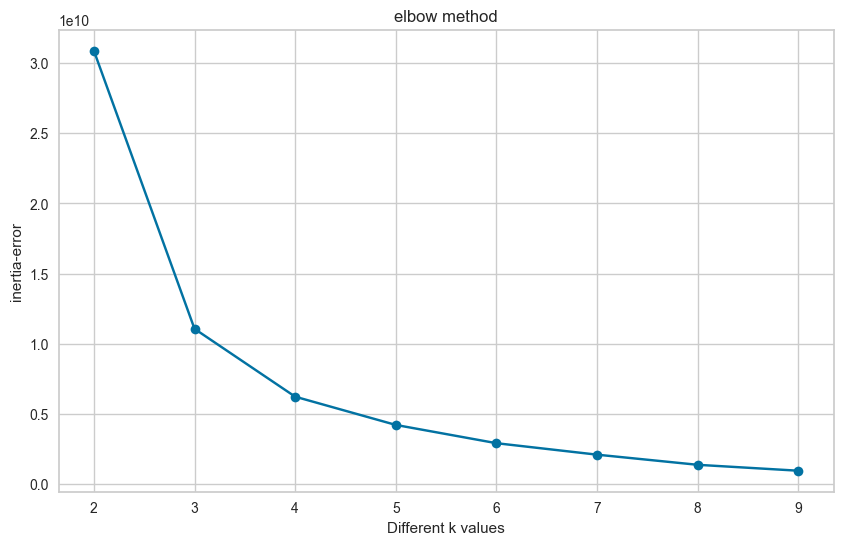

In [66]:
plt.plot(K, ssd, "bo-")
plt.xlabel("Different k values")
plt.ylabel("inertia-error") 
plt.title("elbow method")

In [67]:
from sklearn.metrics import silhouette_score

In [68]:
model = KMeans(n_clusters=4)
model.fit(Customer_Cluster_Table.drop("Main_ID", axis = 1))

KMeans(n_clusters=4)

In [69]:
Customer_Cluster_Table["customer_cluster"] = model.labels_

In [70]:
Customer_Cluster_Table.sample(20)

Main_ID  Total_Price  Total_Frequency  customer_cluster
15099  cad1b06b        263.0               11                 0
6815   b25dd472        117.5                5                 0
47556  bc1e050b          7.5                1                 0
36653  54c15aa0         50.0                1                 0
37628  39799032         39.5                1                 0
15027  d9c5f6f3       1278.5               15                 2
35219  b571d142         73.5                1                 0
21059  51045f8b         26.0                1                 0
46566  399403c5         18.0                2                 0
8097   bc5ad134        433.0                9                 0
46403  aed39084         10.0                1                 0
13131  3ce1d325         54.5                1                 0
24880  0b7c91e5        946.0               10                 2
19079  39cad568        147.0                5                 0
39059  0083ba39         42.0                2                 0
7817   79085581       3193.0               24                 3
49442  f857ed9b        217.0                1                 0
12124  f708a1ea        262.5                3                 0
26958  7e479924        116.0                1                 0
3372   144eaf70       3273.0               27                 3

In [71]:
Product_Cluster_Table = pd.DataFrame()

In [72]:
Product_Cluster_Table["Main_ID"] = df["Main_ID"]

In [73]:
Product_Cluster_Table["Product_Total_Price"] = df["Product_Total_Price"]

In [74]:
Product_Cluster_Table["Total_Product_Amount"] = df["Total_Product_Amount"]

In [75]:
Product_Cluster_Table.head()

Main_ID  Product_Total_Price  Total_Product_Amount
0  90fada91              60667.2                 792.0
1  32270891              60667.2                 792.0
2  32270891             216141.3                5673.0
3  32270891              12954.0                  68.0
4  32270891             235415.0                5975.0

In [76]:
model = KMeans(n_clusters=4)
model.fit(Product_Cluster_Table.drop("Main_ID", axis = 1))

KMeans(n_clusters=4)

In [77]:
Product_Cluster_Table["product_cluster"] = model.labels_

In [78]:
Product_Cluster_Table.sample(20)

Main_ID  Product_Total_Price  Total_Product_Amount  product_cluster
5294   7cb73e40             108331.0                1706.0                3
29264  13d6fa3e             115705.6                1432.0                3
18793  c43fd71d             235415.0                5975.0                0
18164  d40ba5c8             235415.0                5975.0                0
3186   416d124d              60316.0                 887.0                3
41023  912d4cef              63351.4                1223.0                3
33303  39df81bf                223.6                  43.0                1
18555  110deac0             235415.0                5975.0                0
21408  d96368bd              14692.7                 209.0                1
36037  a14866a0              93385.6                1232.0                3
2771   ca30093c              14687.5                 235.0                1
3324   9e79a8d5               5796.0                 168.0                1
48556  ffda5008               5523.3                 171.0                1
16875  dedeb239             235415.0                5975.0                0
22438  d9135166             235415.0                5975.0                0
12436  e588751e             235415.0                5975.0                0
15560  a2f93abd              40167.9                 513.0                1
7942   31e71917               8376.4                 974.0                1
16529  fe54c98e             235415.0                5975.0                0
35614  3b3f9d3a             108331.0                1706.0                3

In [79]:
cluster = pd.merge(Customer_Cluster_Table, Product_Cluster_Table, on = "Main_ID")
cluster.head()

Main_ID  Total_Price  Total_Frequency  customer_cluster  Product_Total_Price  Total_Product_Amount  product_cluster
0  90fada91        125.0                1                 0              60667.2                 792.0                3
1  32270891        825.0                9                 0              60667.2                 792.0                3
2  32270891        825.0                9                 0             216141.3                5673.0                0
3  32270891        825.0                9                 0              12954.0                  68.0                1
4  32270891        825.0                9                 0             235415.0                5975.0                0

In [80]:
cluster = pd.merge(cluster, product_list, on = "Main_ID")
cluster.head()

Main_ID  Total_Price  Total_Frequency  customer_cluster  Product_Total_Price  Total_Product_Amount  product_cluster                             (Code_Product, unique)
0  90fada91        125.0                1                 0              60667.2                 792.0                3                                           [5002.0]
1  32270891        825.0                9                 0              60667.2                 792.0                3  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
2  32270891        825.0                9                 0             216141.3                5673.0                0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
3  32270891        825.0                9                 0              12954.0                  68.0                1  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
4  32270891        825.0                9                 0             235415.0                5975.0                0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...

In [81]:
cluster["Product_List"] = cluster[('Code_Product', 'unique')]

In [82]:
cluster.drop(('Code_Product', 'unique'), axis = 1, inplace=True)

In [83]:
cluster.head()

Main_ID  Total_Price  Total_Frequency  customer_cluster  Product_Total_Price  Total_Product_Amount  product_cluster                                       Product_List
0  90fada91        125.0                1                 0              60667.2                 792.0                3                                           [5002.0]
1  32270891        825.0                9                 0              60667.2                 792.0                3  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
2  32270891        825.0                9                 0             216141.3                5673.0                0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
3  32270891        825.0                9                 0              12954.0                  68.0                1  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...
4  32270891        825.0                9                 0             235415.0                5975.0                0  [5002.0, 49291.5, 5005.0, 49292.0, 5000.5, 495...

In [84]:
RS.head()

5000.5    5001.0    5001.5    5002.0    5003.0    5004.5    5005.0    5007.0    5009.0    5011.5    5012.0    5012.5    5013.0    5015.0    5017.0    5017.5    5023.0    5025.0    5026.0    5027.0    5027.5    10000.5   10001.0   10002.0   10003.0   10003.5   10004.0   10006.0   10013.0   10015.0   10015.5   10021.0   10022.5   10023.0   10023.5   10024.0   10031.0   10032.0   10032.5   10033.0   15000.5   15001.5   15002.0   15002.5   15003.0   15004.0   15004.5   15005.0   15005.5   15008.5   15010.5   15015.0   15015.5   15016.0   15016.5   15020.5   15022.5   15030.5   20005.5   20007.0   20007.5   20014.5   20024.0   20024.5   20025.0   20034.5   25003.0   25003.5   25004.0   25004.5   30002.0   30003.0   30003.5   30008.0   30008.5   30009.0   30009.5   30014.0   30014.5   30021.5   30026.5   30027.0   30029.0   30029.5   35000.5   35001.0   35002.5   35004.5   35005.0   35005.5   35006.0   35006.5   35007.5   35011.0   35011.5   35012.5   35013.5   35018.0   35018.5   \
0   40027.5   40054.0    5007.0    5002.0    5000.5    5004.5   35076.0    5007.0    5009.0   15000.5   10031.0    5012.5   45001.5    5000.5    5017.0   35006.0    5000.5    5025.0    5000.5   30003.5   10003.5    5001.5   10003.0   10002.0   40054.0    5017.0   48589.0   10006.0   40046.0   40027.0   10015.5    5000.5   10022.5   10023.0   20007.5   35005.0    5017.0   49292.0   10032.5   10033.0    5025.0    5009.0   15002.0   49291.5   49291.5   45001.0   49427.5    5000.5    5000.5   10022.5    5000.5    5000.5   15015.5   25003.0   15016.5   40036.0   49291.5    5000.5   20005.5   20007.0   10023.5   10004.0    5000.5   25003.0    5000.5    5011.5   25003.0   35097.0    5017.0   25004.5   10013.0   49427.5   49356.0   25003.5   30008.5   35096.5   45001.0   35005.5   30014.5   48556.5   30026.5   30027.0   10023.0   10023.0   35000.5   30021.5   45004.0   35004.5   10015.0   35005.5   10015.0   40030.0    5000.5    5000.5   10013.0    5000.5    5000.5   45004.0   49292.0   
1   15015.5    5001.0   10033.0   20005.5    5001.0   30026.5   49292.0    5017.0   40027.0   40054.0   40036.0    5017.0   48513.0    5001.0   40028.5   40009.5   45004.0   49427.5    5001.0    5027.0   40069.5   49556.0   10013.0    5000.5   10003.0    5027.5   40002.0   10023.5   10013.0   30029.0   10000.5    5001.0   15008.5   30029.5   30029.0   10024.0   10022.5    5000.5   10003.5   49567.5   15000.5    5000.5   35005.5   49292.0   49292.0   10022.5   40028.5    5001.0    5001.0   15008.5    5001.0    5001.0   49291.5   48513.0   30029.0    5017.0    5000.5    5001.0    5000.5   49292.0   20007.5   49427.5    5001.0    5000.5    5001.0   45004.0   20024.5   25004.5   10023.5   25003.5    5000.5   40028.5    5027.0    5009.0   49292.0   48504.5   45004.0    5012.0   30021.5   35001.0   40021.5   10023.5   10023.5   10023.5   40028.0   40069.5   49291.5   35005.0   10024.0   40043.0   35006.0   45003.0    5001.0    5001.0   35011.5    5001.0    5001.0   49291.5   49291.5   
2   10006.0   40075.5    5001.5   30029.5    5001.5    5011.5    5012.0    5001.0   40020.5    5011.5   10002.0   15016.5    5011.5    5001.5   10031.0   25003.0   49291.5   10004.0    5001.5   15004.5    5011.5   10000.5   25003.5    5001.0   10024.0   10003.5   10004.0    5012.0   35011.5   10015.0   25003.0    5001.5   10031.0   30029.0   30029.5    5001.0   10031.0    5001.0   10015.5   49291.5   40002.0    5001.0   45001.5   45001.0    5000.5    5025.0   35076.0    5001.5    5001.5    5000.5    5001.5    5001.5    5001.0   49567.5   10023.0   49292.0    5001.0   49292.0    5001.0    5000.5    5001.0    5000.5    5001.5    5001.0    5001.5    5000.5   15016.0   10001.0    5001.0   45002.5    5001.0   30008.0   35097.0   45003.0   45004.0   35076.0    5000.5   10003.0   10023.0   15016.5   35001.0    5009.0   15016.5   25003.0   40045.5   35004.5    5025.0   45002.5   40009.5   30014.0   49292.0   49291.5    5001.5    5001.5   49292.0    5001.5    5001.5   48504.5    5000.5   
3   30008.5   10031.0  

In [85]:
cluster.Main_ID.unique()

array(['90fada91', '32270891', '976e7a38', ..., 'c1d4384e', '9704c040',
       '74746892'], dtype=object)

In [86]:
list(cluster.Product_List[cluster.Main_ID == '32270891' ])[0]

array([ 5002. , 49291.5,  5005. , 49292. ,  5000.5, 49567.5, 49356. ,
        5009. ])

for i in np.arange(len(cluster)):
        for j in np.arange(len(cluster.Product_List[i])):
            x = cluster.Product_List[i][j]
            for m in RS.columns:
                if k == m:
                    x = RS[m][0]
                    for 

In [87]:
oneriler = []

for i in cluster.Main_ID.unique():
    for j in np.arange(len(list(cluster.Product_List[cluster.Main_ID == i ])[0])):
        x = list(cluster.Product_List[cluster.Main_ID == i ])[0][j]
        for k in RS.columns:
            if k == x:
                oneriler.append([i,RS[k][0]])
                oneriler.append([i,RS[k][1]])

In [88]:
t = np.unique(oneriler)

In [89]:
t

array(['00024de6', '00084856', '0008e848', ..., 'fff9726b', 'fffa332b',
       'ffff4aa9'], dtype='<U32')

In [98]:
Main_ID = []
Product = []


for i in np.arange(len(oneriler)):
    Main_ID.append(oneriler[i][0])
    Product.append(oneriler[i][1])

In [99]:
df_oneri = pd.DataFrame()

In [100]:
df_oneri["Main_ID"] = Main_ID; df_oneri

Main_ID
0      90fada91
1      90fada91
2      32270891
3      32270891
4      32270891
...         ...
91141  0f52d44e
91142  b0cd1261
91143  b0cd1261
91144  f8170732
91145  f8170732

[91146 rows x 1 columns]

In [101]:
df_oneri["Product"] = Product; df_oneri

Main_ID  Product
0      90fada91   5002.0
1      90fada91  20005.5
2      32270891   5002.0
3      32270891  20005.5
4      32270891  35006.5
...         ...      ...
91141  0f52d44e   5001.0
91142  b0cd1261   5000.5
91143  b0cd1261   5001.0
91144  f8170732   5000.5
91145  f8170732   5001.0

[91146 rows x 2 columns]

In [109]:
df_oneri.drop_duplicates(keep = "first", inplace=True)

In [111]:
df_oneri.Main_ID.value_counts()

734264e5    52
07261a71    41
d0778daf    40
751131ee    38
efbec276    37
            ..
080015b6     2
1b52a77c     2
7314f96d     2
5a8c9071     2
f8170732     2
Name: Main_ID, Length: 28385, dtype: int64